multi-armed bandit parameter study - function-based implementation
recreating sutton & barto figure 2.6

testing epsilon-greedy...
  parameter 2^-7.0 = 0.007812
  parameter 2^-6.0 = 0.015625
  parameter 2^-5.0 = 0.031250
  parameter 2^-4.0 = 0.062500
  parameter 2^-3.0 = 0.125000
  parameter 2^-2.0 = 0.250000

testing gradient bandit...
  parameter 2^-5.0 = 0.031250
  parameter 2^-4.0 = 0.062500
  parameter 2^-3.0 = 0.125000
  parameter 2^-2.0 = 0.250000
  parameter 2^-1.0 = 0.500000
  parameter 2^0.0 = 1.000000
  parameter 2^1.0 = 2.000000

testing upper confidence bound...
  parameter 2^-4.0 = 0.062500
  parameter 2^-3.0 = 0.125000
  parameter 2^-2.0 = 0.250000
  parameter 2^-1.0 = 0.500000
  parameter 2^0.0 = 1.000000
  parameter 2^1.0 = 2.000000
  parameter 2^2.0 = 4.000000

testing greedy with optimistic init...
  parameter 2^-2.0 = 0.250000
  parameter 2^-1.0 = 0.500000
  parameter 2^0.0 = 1.000000
  parameter 2^1.0 = 2.000000
  parameter 2^2.0 = 4.000000


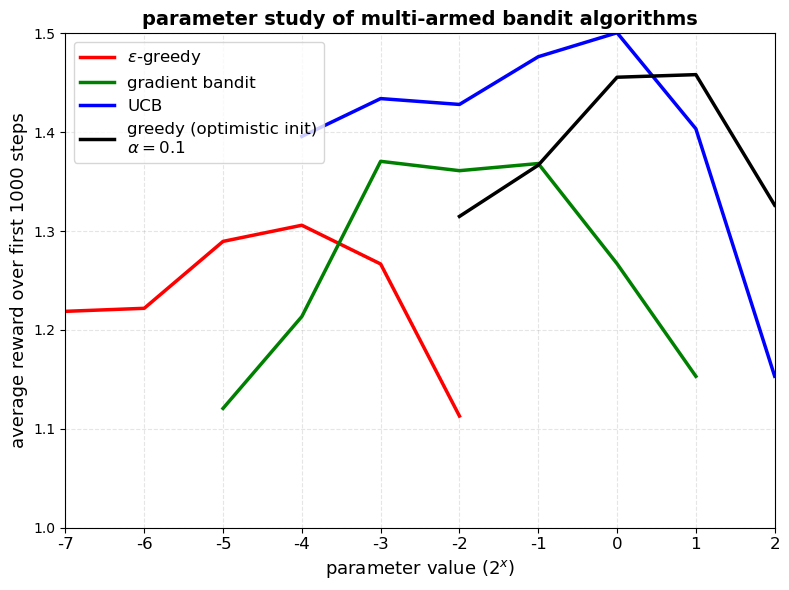

In [1]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Multi-armed Bandit Problem
# multi-armed bandit: figure 2.6 parameter study - function-based implementation
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

def setup_bandit_environment(arm_count=10, reward_center=0.0):
    """
    creates a new bandit problem with random true arm values
    returns the true reward values for each arm
    """
    true_reward_values = np.random.randn(arm_count) + reward_center
    return true_reward_values

def get_noisy_reward(arm_index, true_rewards):
    """
    generates a noisy reward for pulling a specific arm
    reward is normally distributed around the true arm value
    """
    return np.random.randn() + true_rewards[arm_index]

def select_epsilon_greedy_arm(value_estimates, exploration_rate):
    """
    chooses arm using epsilon-greedy strategy
    explores with probability exploration_rate, otherwise picks best estimated arm
    """
    if np.random.rand() < exploration_rate:
        return np.random.choice(len(value_estimates))
    else:
        max_value = np.max(value_estimates)
        best_arms = np.where(value_estimates == max_value)[0]
        return np.random.choice(best_arms)

def select_ucb_arm(value_estimates, pull_counts, timestep, confidence_level):
    """
    chooses arm using upper confidence bound
    adds confidence bonus based on uncertainty and exploration need
    """
    if timestep == 0:
        return np.random.choice(len(value_estimates))
    
    confidence_bonuses = confidence_level * np.sqrt(
        np.log(timestep) / (pull_counts + 1e-10)
    )
    ucb_values = value_estimates + confidence_bonuses
    return np.argmax(ucb_values)

def compute_softmax_probabilities(preference_values):
    """
    converts preference values to action probabilities using softmax
    numerically stable implementation
    """
    max_pref = np.max(preference_values)
    exp_prefs = np.exp(preference_values - max_pref)
    return exp_prefs / np.sum(exp_prefs)

def select_gradient_bandit_arm(preference_values):
    """
    chooses arm using gradient bandit with softmax action probabilities
    returns both the chosen arm and the probability distribution
    """
    action_probabilities = compute_softmax_probabilities(preference_values)
    chosen_arm = np.random.choice(len(preference_values), p=action_probabilities)
    return chosen_arm, action_probabilities

def update_value_estimate_sample_average(current_estimate, new_reward, pull_count):
    """
    updates value estimate using sample averaging
    maintains exact average of all rewards received for this arm
    """
    return current_estimate + (new_reward - current_estimate) / pull_count

def update_value_estimate_constant_step(current_estimate, new_reward, step_size):
    """
    updates value estimate using constant step size
    gives more weight to recent rewards (exponential recency weighting)
    """
    return current_estimate + step_size * (new_reward - current_estimate)

def update_gradient_preferences(preferences, chosen_arm, reward, baseline_reward, 
                              action_probs, step_size):
    """
    updates all preference values using policy gradient rule
    increases preference for chosen arm if reward above baseline
    """
    reward_advantage = reward - baseline_reward
    
    for arm_idx in range(len(preferences)):
        if arm_idx == chosen_arm:
            # increase preference for chosen arm based on advantage
            preferences[arm_idx] += step_size * reward_advantage * (1 - action_probs[arm_idx])
        else:
            # decrease preferences for non-chosen arms  
            preferences[arm_idx] -= step_size * reward_advantage * action_probs[arm_idx]
    
    return preferences

def run_single_parameter_experiment(strategy_type, param_value, total_runs=2000, 
                                   max_steps=1000, arm_count=10):
    """
    runs experiment for one parameter value across multiple independent runs
    returns average reward across all runs and steps
    """
    cumulative_rewards = 0
    total_steps_all_runs = total_runs * max_steps
    
    for run_number in range(total_runs):
        # create fresh bandit problem for this run
        true_rewards = setup_bandit_environment(arm_count)
        
        # initialize variables based on strategy type
        if strategy_type == 'optimistic_greedy':
            value_estimates = np.full(arm_count, param_value)  # param_value is initial Q
            learning_rate = 0.1  # fixed for optimistic initialization
        else:
            value_estimates = np.zeros(arm_count)
            
        pull_counts = np.zeros(arm_count)
        
        # gradient bandit specific initialization
        if strategy_type == 'gradient_bandit':
            preference_values = np.zeros(arm_count)
            running_reward_average = 0
            
        # run single experiment for max_steps
        for step in range(max_steps):
            # select arm based on strategy
            if strategy_type == 'epsilon_greedy':
                chosen_arm = select_epsilon_greedy_arm(value_estimates, param_value)
                
            elif strategy_type == 'ucb':
                chosen_arm = select_ucb_arm(value_estimates, pull_counts, step, param_value)
                
            elif strategy_type == 'gradient_bandit':
                chosen_arm, action_probabilities = select_gradient_bandit_arm(preference_values)
                
            elif strategy_type == 'optimistic_greedy':
                chosen_arm = select_epsilon_greedy_arm(value_estimates, 0.0)  # pure greedy
                
            # get reward and update counts
            step_reward = get_noisy_reward(chosen_arm, true_rewards)
            pull_counts[chosen_arm] += 1
            cumulative_rewards += step_reward
            
            # update estimates based on strategy
            if strategy_type in ['epsilon_greedy', 'ucb']:
                # use sample averaging for these strategies
                value_estimates[chosen_arm] = update_value_estimate_sample_average(
                    value_estimates[chosen_arm], step_reward, pull_counts[chosen_arm]
                )
                
            elif strategy_type == 'optimistic_greedy':
                # use constant step size for optimistic initialization
                value_estimates[chosen_arm] = update_value_estimate_constant_step(
                    value_estimates[chosen_arm], step_reward, learning_rate
                )
                
            elif strategy_type == 'gradient_bandit':
                # update running average reward baseline
                running_reward_average += (step_reward - running_reward_average) / (step + 1)
                
                # update preferences using policy gradient
                preference_values = update_gradient_preferences(
                    preference_values, chosen_arm, step_reward, running_reward_average,
                    action_probabilities, param_value  # param_value is step_size here
                )
    
    # return average reward per step across all runs
    return cumulative_rewards / total_steps_all_runs

def conduct_parameter_sweep_study(experiment_runs=1000, experiment_steps=1000):
    """
    recreates sutton & barto figure 2.6 comparing bandit algorithm parameter sensitivity
    tests each algorithm across range of parameter values using powers of 2
    """
    
    # algorithm configuration
    strategy_names = [
        'epsilon-greedy',
        'gradient bandit', 
        'upper confidence bound',
        'greedy with optimistic init'
    ]
    
    strategy_types = [
        'epsilon_greedy',
        'gradient_bandit', 
        'ucb',
        'optimistic_greedy'
    ]
    
    # parameter ranges as powers of 2
    param_power_ranges = [
        np.arange(-7, -1, dtype=np.float64),  # epsilon: 2^-7 to 2^-2
        np.arange(-5, 2, dtype=np.float64),   # alpha: 2^-5 to 2^1
        np.arange(-4, 3, dtype=np.float64),   # c: 2^-4 to 2^2
        np.arange(-2, 3, dtype=np.float64)    # q0: 2^-2 to 2^2
    ]
    # note: ranges chosen to match figure 2.6 in sutton & barto
    
    # collect results for plotting
    all_algorithm_results = []
    all_param_values = []
    
    for strategy_idx, (strategy_name, strategy_type, power_range) in enumerate(
        zip(strategy_names, strategy_types, param_power_ranges)
    ):
        print(f"\ntesting {strategy_name}...")
        
        algorithm_performance = []
        param_values = []
        
        for power_exponent in power_range:
            # convert power of 2 to actual parameter value
            actual_param = pow(2, power_exponent)
            param_values.append(power_exponent)  # store exponent for x-axis
            
            print(f"  parameter 2^{power_exponent:.1f} = {actual_param:.6f}")
            
            # run experiment with this parameter value
            avg_performance = run_single_parameter_experiment(
                strategy_type, actual_param, experiment_runs, experiment_steps
            )
            
            algorithm_performance.append(avg_performance)
            
        all_algorithm_results.append(algorithm_performance)
        all_param_values.append(param_values)
    
    # create comparison plot
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'black']
    labels = [r'$\varepsilon$-greedy', 'gradient bandit', 'UCB', 'greedy (optimistic init)\n$\\alpha=0.1$']

    for i, (param_vals, perf, color, label) in enumerate(zip(all_param_values, all_algorithm_results, colors, labels)):
        plt.plot(param_vals, perf, color=color, linewidth=2.5, label=label)

    plt.xticks(
        ticks=[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2],
        labels=[f'{int(v)}' for v in [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2]],
        fontsize=12
    )
    plt.xlabel('parameter value ($2^x$)', fontsize=13)
    plt.ylabel('average reward over first 1000 steps', fontsize=13)
    plt.title('parameter study of multi-armed bandit algorithms', fontsize=14, fontweight='bold')
    plt.ylim(1.0, 1.5)
    plt.xlim(-7, 2)
    plt.grid(True, which='both', color='gray', alpha=0.2, linestyle='--')
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    
if __name__ == "__main__":
    print("multi-armed bandit parameter study - function-based implementation")
    print("recreating sutton & barto figure 2.6")
    
    # run parameter study with moderate settings for reasonable execution time
    conduct_parameter_sweep_study(experiment_runs=800, experiment_steps=1000)